[ 1 10  3  1 10  3]


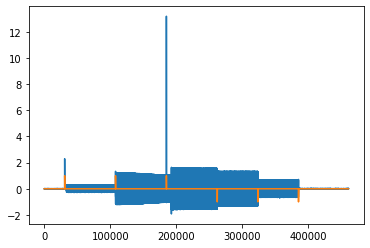

In [5]:
import numpy as np
import h5py
#from model_train_fullData import plot, plotSignal
from Plot import Plot

arquivo = h5py.File("Synthetic_Full_iHall.hdf5", "r")

signal = arquivo["3"]["i"][2]
events = arquivo["3"]["events"][2]
label = arquivo["3"]["labels"][2]

print(label)

Plot.plot(signal, events, 0, signal.shape[0])

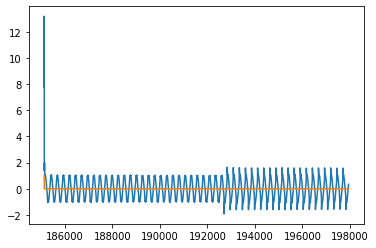

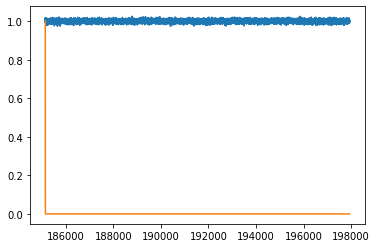

In [13]:
events_list = np.argwhere(events == 1)
Plot.plot(signal, events, events_list[2][0], events_list[2][0] + 12800)

from SignalProcessing import SignalProcessing

noise_signal = SignalProcessing.awgn(np.ones(signal.shape), 40)
Plot.plot(noise_signal, events, events_list[2][0], events_list[2][0] + 12800)

In [ ]:
from random import randrange

init_offset = events_list[2][0] - randrange(0, 12800)
plot(signal, events, init_offset, init_offset + 12800)

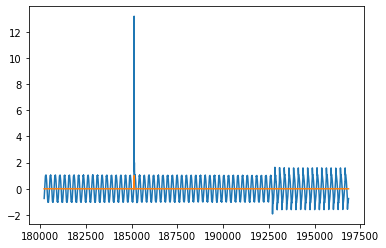

In [25]:
plot(signal, events, init_offset - int(0.15 * 12800), init_offset + 12800 + int(0.15 * 12800))

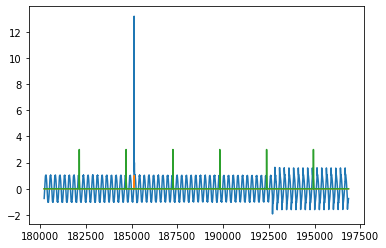

In [26]:
grids_division = np.zeros(signal.shape)

for i in range(6):
    grids_division[init_offset + 2560 * i] = 3

plot(signal, events, init_offset - int(0.15 * 12800), init_offset + 12800 + int(0.15 * 12800), grids_division=grids_division)

In [27]:
gridLength = int(12800 / 5)
randomizedInitCoordinates = init_offset
initIndex = events_list[2][0]
N_GRIDS = 5
N_CLASS = 26

glob_signal_events = np.argwhere(events != 0)
if len(glob_signal_events) != len(label):
    print("Quantidade de eventos encontrados não corresponde ao esperado")
    exit(-1)

label_events_tuple = list(zip(label, np.transpose(glob_signal_events)[0])) # cria tuplas com a coordenada do evento e o seu respectivo label (label, amostra de ocorrencia do evento)
events_duration = []
while len(label_events_tuple) != 0:
    for i in range(1, len(label_events_tuple)):
        if(label_events_tuple[0][0] == label_events_tuple[i][0]):
            events_duration.append([label_events_tuple[0][0], label_events_tuple[0][1], label_events_tuple[i][1]])
            del label_events_tuple[i]
            del label_events_tuple[0]
            break

out_detection = np.zeros((N_GRIDS, 1))
out_classification = np.zeros((N_GRIDS, N_CLASS))
out_type = np.zeros((N_GRIDS, 3))   

'''
for i in range(N_GRIDS):
    out_classification[i][N_CLASS] = 1
'''

for grid in range(N_GRIDS):
    if initIndex >= randomizedInitCoordinates + (grid * gridLength) and initIndex < randomizedInitCoordinates + (grid + 1) * gridLength:
        out_detection[grid][0] = (initIndex - (randomizedInitCoordinates + (grid * gridLength)))/gridLength
        if events[initIndex] == 1: # ON
            out_type[grid][0] = 1
        else: # OFF
            out_type[grid][1] = 1
    else:
        out_type[grid][2] = 1
    
    for load in events_duration:
        begin_coord = randomizedInitCoordinates + (grid * gridLength)
        end_coord = begin_coord + gridLength
        out_classification[grid][load[0]] = max(0, (min(end_coord, load[2]) - max(begin_coord, load[1])) / gridLength)

In [28]:
print(out_detection)
print(out_type)
print(out_classification)

[[0.        ]
 [0.17070313]
 [0.        ]
 [0.        ]
 [0.        ]]
[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]
[[0.         1.         0.         0.         0.         0.
  0.         0.         0.         0.         1.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         1.         0.         0.82929688 0.         0.
  0.         0.         0.         0.         1.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         1.         0.         1.         0.         0.
  0.         0.         0.         0.         1.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         1.         0.         1.         0.         0.
  0.         

<Figure size 1800x1200 with 0 Axes>

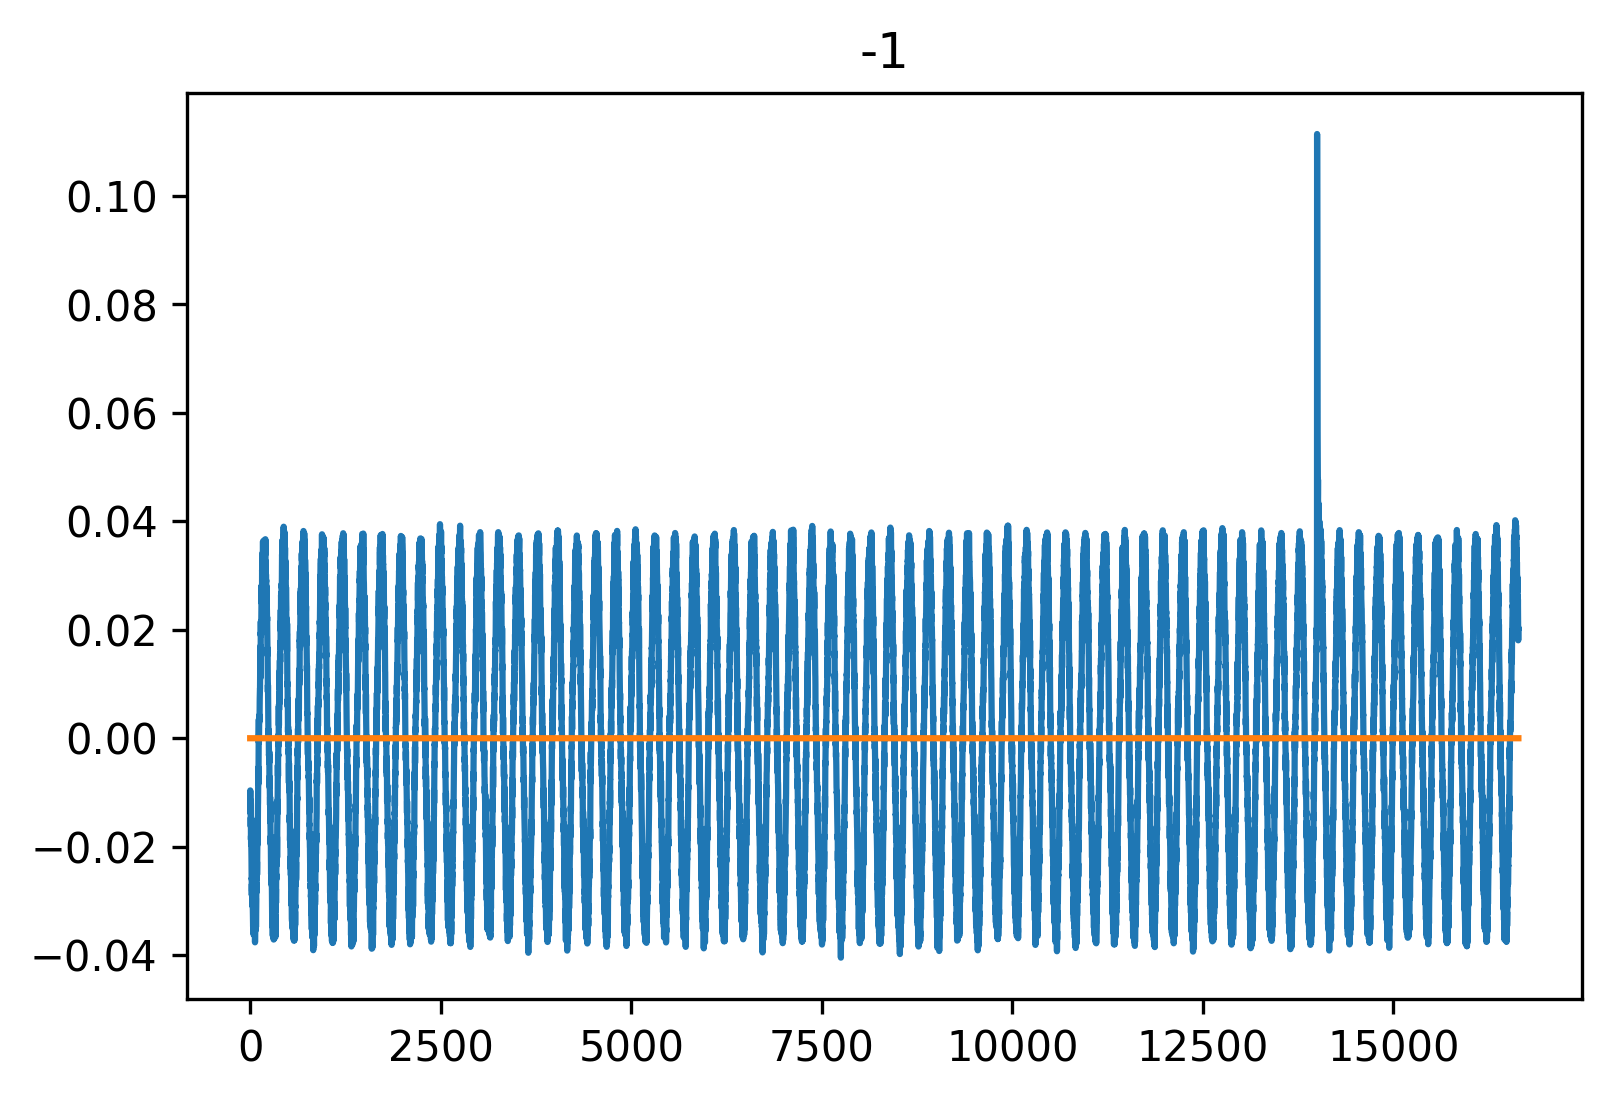

In [3]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

import pickle
from Plot import Plot
from PostProcessing import PostProcessing

folderDataPath = "Weights/MultiLabel/5/"
ngrids = 5
signalBaseLength = 12800

configs = {
    "N_GRIDS": 5, 
    "SIGNAL_BASE_LENGTH": 12800, 
    "N_CLASS": 26, 
    "USE_NO_LOAD": False, 
    "AUGMENTATION_RATIO": 1, 
    "MARGIN_RATIO": 0.15, 
    "DATASET_PATH": "Synthetic_Full_iHall.hdf5",
    "TRAIN_SIZE": 0.8,
    "FOLDER_PATH": "Weights/MultiLabel/7/", 
    "FOLDER_DATA_PATH": "Weights/MultiLabel/2/", 
    "N_EPOCHS_TRAINING": 50,
    "INITIAL_EPOCH": 50,
    "TOTAL_MAX_EPOCHS": 250,
    "SNRdb": 10 # Nível de ruído em db
}

postProcessing = PostProcessing(configs=configs)

dict_data = pickle.load(open(folderDataPath + "sorted_aug_data_" + str(ngrids) + "_" + str(signalBaseLength) + ".p", "rb"))
x_train = dict_data["x_train"]
x_test = dict_data["x_test"]
y_train = dict_data["y_train"]
y_test = dict_data["y_test"]


ydet, ytype, yclass = postProcessing.processResult(y_train["detection"][0], y_train["type"][0], y_train["classification"][0])
Plot.plotSignal(x_train[0], ydet, ytype, yclass)